In [1]:
import re
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
WORKING_DIR = os.path.join('.input', 'logistic')

In [4]:
quora = pd.read_csv('../data/.input/train.csv')

In [5]:
quora.head(10)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


In [6]:
quora_train, quora_test = train_test_split(quora, random_state=42)
quora_train_data = quora_train.question_text
quora_train_labels = quora_train.target
quora_test_data = quora_test.question_text
quora_test_labels = quora_test.target

In [7]:
%time
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

train_X = vectorizer.fit_transform(quora_train_data)
train_y = quora_train_labels

Wall time: 0 ns


In [8]:
test_X = vectorizer.transform(quora_test_data)
test_y = quora_test_labels

In [9]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

params = {
    'n_estimators': sp_randint(5, 200), 
    'min_samples_split': sp_randint(2, 11), 
    'bootstrap': [True, False], 
    'criterion': ["gini", "entropy"]}
clf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(clf, param_distributions=params,
                                   n_iter=20, cv=3, n_jobs=-1)

random_search.fit(train_X, train_y)

Wall time: 1d 9h 9min 20s


In [10]:
clf = random_search.best_estimator_
clf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=37, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

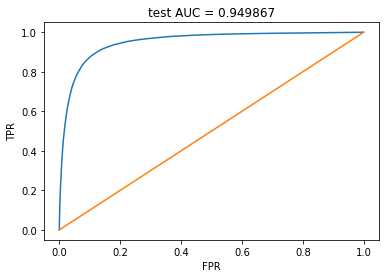

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve

test_predict_proba = clf.predict_proba(test_X)
test_predict_proba_pos = test_predict_proba[:, 1]
auc = roc_auc_score(test_y, test_predict_proba_pos)
curve = roc_curve(test_y, test_predict_proba_pos)


plt.plot(curve[0], curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

to_labels = np.vectorize(lambda x: 1 if x > 0.5 else 0)
test_predict = to_labels(test_predict_proba_pos)

print('accuracy', accuracy_score(test_y, test_predict))
print('precision', precision_score(test_y, test_predict))
print('recall', recall_score(test_y, test_predict))
print('f1', f1_score(test_y, test_predict))
confusion_matrix(test_y, test_predict)


accuracy 0.945456939769884
precision 0.8106215348701488
recall 0.1393249410702643
f1 0.23778139176581356


array([[305943,    649],
       [ 17161,   2778]], dtype=int64)

In [15]:
for mean_score, params in zip(random_search.cv_results_['mean_test_score'], random_search.cv_results_['params']):
    print(mean_score, params)

0.9419196378896907 {'bootstrap': True, 'criterion': 'entropy', 'min_samples_split': 5, 'n_estimators': 40}
0.9421421797464452 {'bootstrap': False, 'criterion': 'entropy', 'min_samples_split': 10, 'n_estimators': 177}
0.942948638768629 {'bootstrap': False, 'criterion': 'entropy', 'min_samples_split': 6, 'n_estimators': 31}
0.9431946598121053 {'bootstrap': False, 'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 81}
0.9415041583681353 {'bootstrap': True, 'criterion': 'entropy', 'min_samples_split': 5, 'n_estimators': 129}
0.942217721477637 {'bootstrap': False, 'criterion': 'entropy', 'min_samples_split': 8, 'n_estimators': 165}
0.9432099723251847 {'bootstrap': False, 'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 37}
0.942258554845849 {'bootstrap': True, 'criterion': 'gini', 'min_samples_split': 5, 'n_estimators': 141}
0.9413398040610826 {'bootstrap': True, 'criterion': 'entropy', 'min_samples_split': 9, 'n_estimators': 72}
0.941693012696115 {'bootstrap': True, 

In [18]:
print(random_search.best_score_, random_search.best_params_)

0.9432099723251847 {'bootstrap': False, 'criterion': 'gini', 'min_samples_split': 10, 'n_estimators': 37}
